In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
from tqdm import tqdm

In [2]:
test_data = pd.read_csv('data/test.tsv',sep='\t')
train_data = pd.read_csv('data/train.tsv',sep='\t')

词袋模型
1、将数据进行划分，提取单词 
2、将单词转换为向量
3、将句子使用向量表示


In [3]:
def BoW_tokenize(data):
    words_set=set()
    for sentence in data:
        #sentence=re.sub(r'[^\w\s]',' ',sentence) #去除标点符号
        words_set.update(sentence.split())
    return words_set #return a set of words

def BoW_vectorize(data,words_set):
    vector_size=len(words_set)
    feature_vector=np.zeros((len(data),vector_size),dtype=np.int8)
    vector_map=dict(zip(words_set,range(vector_size)))
    for sentence_index,sentence in enumerate(data):
        #sentence=re.sub(r'[^\w\s]',' ',sentence) #去除标点符号
        for word in sentence.split():
            if word in words_set:
                feature_vector[sentence_index,vector_map[word]]+=1
    # 使用n维向量表示句子，每个维度表示一个单词，值为单词出现的次数
    return feature_vector

使用Ngram模型，将句子转换为向量

In [4]:
def Ng_tokenize(data , n=2):
    words_set=set()
    for sentence in data:
        #sentence=re.sub(r'[^\w\s]',' ',sentence) # 去除标点符号
        word_list=sentence.split()
        for i in range(len(word_list)-n):
            words_set.add(' '.join(word_list[i:i+n]))
    
    return words_set

def Ng_vectorize(data,words_set,n=2):
    vector_size=len(words_set)
    feature_vector=np.zeros((len(data),vector_size),dtype=np.int8)
    vector_map=dict(zip(words_set,range(vector_size)))
    for sentence_index,sentence in enumerate(data):
        #sentence=re.sub(r'[^\w\s]',' ',sentence) # 去除标点符号
        word_list=sentence.split()
        for i in range(len(word_list)-n):
            if ' '.join(word_list[i:i+n]) in words_set:
                feature_vector[sentence_index,vector_map[' '.join(word_list[i:i+n])]]+=1
    return feature_vector

划分Train、Val数据集

In [5]:
def train_val_split(X,y,val_rate=0.8):
    X_size=X.shape[0]
    train_size=int((1-val_rate)*X_size)
    index = [i for i in range(X_size)] 
    # print(train_size)
    random.shuffle(index)
    train_X = X[index[0:train_size]]
    train_y = y[index[0:train_size]]
    val_X = X[index[train_size:]]
    val_y = y[index[train_size:]]
    # print(train_X.shape,val_X.shape,train_y.shape,val_y.shape)
    return train_X,val_X,train_y,val_y

In [6]:
def train(train_X,train_y,val_X,val_y,batchsize=32,lr=1e0,epoch_number=100,class_number=5):
    iter_number=train_X.shape[0]//batchsize
    weight=np.zeros((train_X.shape[1],class_number))
    # 不同初始值的影响
    # weight=np.random.normal(0,1,[train_X.shape[1],class_number])
    train_loss_list=[]
    test_loss_list=[]
    for i in range(epoch_number):
        train_loss=0
        test_loss=0
        for j in tqdm(range(iter_number)):
            train_data=train_X[j*batchsize:j*batchsize+batchsize]
            y_train=train_y[j*batchsize:j*batchsize+batchsize]
            y=np.exp(train_data.dot(weight))   
            y_hat=np.divide(y.T,np.sum(y,axis=1)).T
            train_loss+= (-1/train_X.shape[0])*np.sum(np.multiply(y_train,np.log10(y_hat)))
            # 每个batch权重更新一次
            weight+=(lr/batchsize)*train_data.T.dot(y_train-y_hat)
       
        y=np.exp(val_X.dot(weight))   
        y_hat=np.divide(y.T,np.sum(y,axis=1)).T
        test_loss= (-1/val_X.shape[0])*np.sum(np.multiply(val_y,np.log10(y_hat)))
        # print('train_loss:',train_loss," test_loss:",test_loss)
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
    
    return train_loss_list,test_loss_list,weight

In [7]:
def CreateFeature(ngram=2,analyzer='word'):
    feature_set=BoW_tokenize(data=train_data['Phrase'].to_numpy())
    X=BoW_vectorize(data=train_data['Phrase'].to_numpy(),words_set=feature_set)
    test_X=BoW_vectorize(data=test_data['Phrase'].to_numpy(),words_set=feature_set)
    return feature_set,X,test_X

In [8]:
def drawpic(train_loss_list=[],test_loss_list=[],epoch_number=10,path='1.jpg'):
    # make data
    x = [i for i in range(epoch_number)]
    # plot
    fig, ax = plt.subplots()
    ax.plot(x, train_loss_list, linewidth=2.0)
    ax.plot(x, test_loss_list, linewidth=2.0)
    plt.savefig(path)
    plt.show()

In [9]:
class_number=5
y=train_data['Sentiment'].to_numpy()
y_onehot=np.zeros((y.shape[0],class_number)).astype('int16')
for i in range(y.shape[0]):
    y_onehot[i,y[i]]+=1



parameter_list=[
    #{'ngram':2,'analyzer':'word','batchsize':32,"lr":1e0,'epoch_number':20,'val_rate':0.2},
    #{'ngram':2,'analyzer':'word','batchsize':8,"lr":1e0,'epoch_number':20,'val_rate':0.2},
    #{'ngram':2,'analyzer':'word','batchsize':128,"lr":1e0,'epoch_number':20,'val_rate':0.2},
    #{'ngram':2,'analyzer':'word','batchsize':32,"lr":1e1,'epoch_number':20,'val_rate':0.2},
    {'ngram':2,'analyzer':'word','batchsize':128,"lr":1e0,'epoch_number':40,'val_rate':0.2},

]

def flow(parameter_list):
    for parameter_dict in parameter_list:
        
        ngram=parameter_dict['ngram']
        analyzer=parameter_dict['analyzer']
        batchsize=parameter_dict['batchsize']
        lr=parameter_dict['lr']
        epoch_number=parameter_dict['epoch_number']
        val_rate=parameter_dict['val_rate']

        
        feature_set,X,test_X=CreateFeature(ngram=ngram,analyzer=analyzer)

        train_X,val_X,train_y,val_y=train_val_split(X,y_onehot,val_rate=val_rate)
        train_loss_list,test_loss_list,weight=train(train_X=train_X,train_y=train_y,val_X=val_X,val_y=val_y,batchsize=batchsize,lr=lr,epoch_number=epoch_number)
        

        y_temp=np.exp(val_X.dot(weight))   
        y_temp=np.divide(y_temp.T,np.sum(y_temp,axis=1)).T
        y_predict=np.array([np.argmax(i) for i in y_temp])
        y_val=np.array([np.argmax(i) for i in val_y])

        acc=np.sum(y_predict.astype('int')==y_val.astype('int'))/y_val.shape[0]
        parameter_dict['acc']='%.4f' % acc
        print('acc:',acc)

        parameter_dict['best_train_loss']='%.4f' % np.min(train_loss_list) 
        parameter_dict['best_test_loss']='%.4f' % np.min(test_loss_list)
        
        print('train_loss:',parameter_dict['best_train_loss']," test_loss:",parameter_dict['best_test_loss'])
      
        path='pic/ngram_{}-analyzer_{}-lr_{}-batchsize_{}-epoch_number_{}-val_rate_{}.jpg'.format(str(ngram),str(analyzer),str(lr),str(batchsize),str(epoch_number),str(val_rate))
        parameter_dict['path']=path
        print(path)
        drawpic(train_loss_list=train_loss_list,test_loss_list=test_loss_list,epoch_number=epoch_number,path=path)
    return parameter_list

100%|██████████| 975/975 [00:10<00:00, 90.39it/s]


acc: 0.5484108676150199
train_loss: 0.4391  test_loss: 0.5181
pic/ngram_2-analyzer_word-lr_1.0-batchsize_128-epoch_number_40-val_rate_0.2.jpg


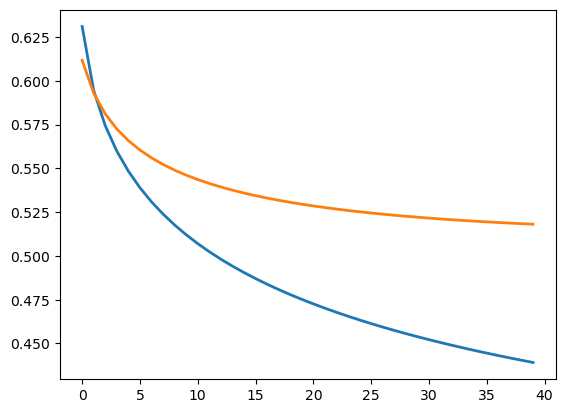

In [10]:
parameter_list=flow(parameter_list)